In [4]:
from pandas.io.json import json_normalize
import json

In [1]:
import json
from shapely.ops import polygonize
from shapely.geometry import asShape
from shapely.geometry import mapping

In [13]:
with open('warszawa_dzielnice.geojson', 'r') as f:
    warszawa = json.load(f)

In [22]:
warsaw_borders = warszawa['features'][0]['geometry']['coordinates'][0][0]

In [30]:
from shapely.geometry import box, Polygon, MultiPolygon

def fishnet(geometry, threshold):
    bounds = geometry.bounds
    xmin = int(bounds[0] // threshold)
    xmax = int(bounds[2] // threshold)
    ymin = int(bounds[1] // threshold)
    ymax = int(bounds[3] // threshold)
    ncols = int(xmax - xmin + 1)
    nrows = int(ymax - ymin + 1)
    result = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*threshold, j*threshold, (i+1)*threshold, (j+1)*threshold)
            g = geometry.intersection(b)
            if g.is_empty:
                continue
            result.append(g)
    return result

In [25]:
pol_warsaw_borders = Polygon(warsaw_borders)

In [93]:
splitted_warsaw = fishnet(pol_warsaw_borders, 0.015)

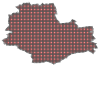

In [94]:
MultiPolygon(splitted_warsaw)

In [95]:
len(splitted_warsaw)

363

In [96]:
var = splitted_warsaw[100]

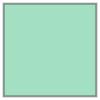

In [97]:
var

In [100]:
with open("MAD/data/warsaw_splitted.json", 'r') as file:
    polygz = json.load(file)

In [101]:
lines = []
for feature in polygz['features']:
    lines.append(asShape(feature['geometry']))

In [111]:
a = lines[0]

In [114]:
a.centroid.xy[0][0]

20.859501785212608

In [7]:
polys = list(polygonize(lines))

geojson = {
    "type": "FeatureCollection",
    "features": []
}

In [12]:
for poly in polys:
    geojson['features'].append({
        "type": "Feature",
        "properties": {},
        "geometry": mapping(poly)
    })

json.dump(geojson, open('polygonds_sciezki.json', 'w'))

In [104]:
import requests

In [105]:
r = requests.get("http://api.locit.pl/webservice/catchment-data/v2.0.0/941/52.177499999999995/20.9775?format=json&charset=UTF-8", 
                headers={'Authorization': 'maraton0n895gbsgc72bbksa042mad17', 'accept': "application/json"})

In [161]:
sample = json.load(open('MAD/data/mapped_bike_path.json', 'r'))['features']

In [162]:
sample2 = json.load(open('MAD/data/nested_data_with_datawise.json', 'r'))['features']

In [168]:
s1 = json.load(open('MAD/data/mapped_bike_path.json', 'r'))
s2 = json.load(open('MAD/data/nested_data_with_datawise.json', 'r'))

for x, y in zip(s1['features'],s2['features']):
    y['properties']['length'] = x['properties']['length']

In [171]:
json.dump(s2, open('MAD/data/geo.json', 'w'))

In [163]:
lines = []

for x, y in zip(sample, sample2):
    y['properties']['length'] = x['properties']['length']
    lines.append(y['properties'])

In [387]:
init = pd.DataFrame(lines)

In [388]:
cols = [i for i in init.columns
        if not i.startswith('blud') 
        and not i.startswith('sklep')
        and not i.startswith('poi') 
        and i not in ['mwg7d', 'promien_bufora_km', 'wsp_klasa', 'wsp_x', 'wsp_y', 'id']
       ]

In [314]:
205 in init[init.ludn == '0'].index

True

In [166]:
%matplotlib inline

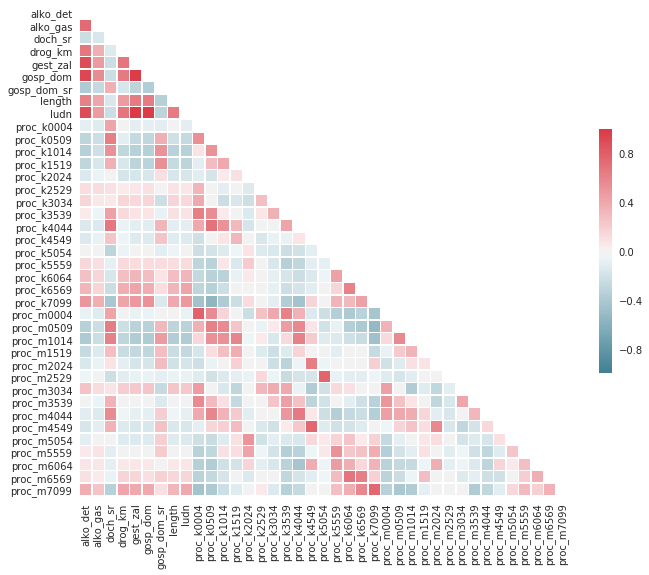

In [389]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = init.loc[:, cols]
d = d.apply(lambda x: pd.to_numeric(x, errors='coerce'))
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [172]:
d.to_csv('MAD/data/data.csv', index=False)

In [200]:
d.columns[(d.describe().loc['max'] > 1000)]

Index(['doch_sr', 'gest_zal', 'gosp_dom', 'length', 'ludn'], dtype='object')

In [390]:
d = d[d['ludn'] != 0]

In [391]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

y = d.length/1000
d = d.drop(['length'], axis=1)

In [392]:
sc = StandardScaler()
d.loc[:,d.columns[(d.describe().loc['max'] > 1000)]] = sc.fit_transform(d.loc[:, d.columns[(d.describe().loc['max'] > 1000)]])

In [393]:
X = d.reset_index()

In [394]:
X = X.drop(['index'], axis=1)

In [395]:
y = y.values

In [398]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error , mean_absolute_error

model = RandomForestRegressor(n_estimators=700,
                      n_jobs=3,
                      max_depth=5,verbose=0,
                      random_state=2017)
loo = LeaveOneOut()

pred = []
for train, test in loo.split(X):
#     print(train, test)
    model.fit(X.iloc[train,:], y[train])
    pred.append(model.predict(X.iloc[test, :])[0])

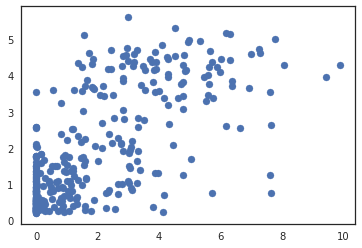

In [399]:
plt.scatter(y, pred)

In [401]:
print(mean_absolute_error(y, pred), mean_squared_error(y, pred))

1.0968009774185932 2.305587802337828


In [402]:
ddd = {}
pred_pred = model.predict(X)
for i in range(0,len(pred)):
    ddd[i] = pred_pred[i] - y[i]

In [403]:
sorted(ddd.items(), key=lambda x: x[1], reverse=True)[0:5]

[(175, 2.370866768479253),
 (359, 2.0645291661445726),
 (24, 1.9737675547616236),
 (155, 1.8188023006119745),
 (179, 1.809174937735162)]

In [296]:
from sklearn.metrics import mean_squared_error , mean_absolute_error
print(mean_squared_error(y, np.array(pred)), mean_absolute_error(y, np.array(pred)))

2.272704440826469 1.1019203761441068


In [378]:
model.predict(X)[175]-y[175]

2.181491326518503

In [421]:
init = init.apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [424]:
for i in zip(init.columns[(init.describe().loc['max'] > 1000)],sc.scale_, sc.mean_):
    print(i)

('doch_sr', 764.9018491662997, 5179.394444444444)
('gest_zal', 3685.137442533542, 2987.163888888889)
('gosp_dom', 5712.573797397271, 4392.438888888889)
('length', 10247.260365917984, 8306.355555555556)


In [407]:
from eli5 import show_prediction
show_prediction(model, X.iloc[175], show_feature_values=True)

In [426]:
show_prediction(model, X.iloc[359], show_feature_values=True)

In [ ]:
k = 0
for i, a in enumerate(s2['features']):
    if i not in init[init.ludn == '0'].index:
        print(i-k)
        a['properties']['pred_value'] = pred_pred[i-k]
        a['properties']['diff_with_real'] = pred_pred[i-k] if pred_pred[i-k] - y[i-k] > 0 else 0
    else:
        k+=1
        a['properties']['pred_value'] = 0
        a['properties']['diff_with_real'] = 0
        

In [406]:
json.dump(s2, open('MAD/data/final_data2.json', 'w'))

In [427]:
import pickle

In [430]:
pickle.dump(model, open('MAD/rf.pickle', 'wb'))